In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statistics
import os
import tqdm
from os.path import exists
from PIL import Image, ImageDraw, ImageFont
import cv2
from glob import glob
import copy

In [ ]:
# 認証のためのコード
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#a,b,cの3地点の座標を表すタプルからそれらのなす角を算出
def angle(a_tup, b_tup, c_tup):
    # 点A,B,Cの座標（3次元座標上の場合）
    a = np.array(a_tup)
    b = np.array(b_tup)
    c = np.array(c_tup)

    # ベクトルを定義
    vec_a = a - b
    vec_c = c - b

    # コサインの計算
    length_vec_a = np.linalg.norm(vec_a)
    length_vec_c = np.linalg.norm(vec_c)
    inner_product = np.inner(vec_a, vec_c)
    cos = inner_product / (length_vec_a * length_vec_c)

    # 角度（ラジアン）の計算
    rad = np.arccos(cos)

    # 弧度法から度数法（rad ➔ 度）への変換
    degree = round(np.rad2deg(rad))
    if degree < 0:
        degree += 360
    return degree
    print("角度")
    print(degree)

In [ ]:
#a,b間の距離
def distance(a_tup, b_tup):
    return (((a_tup[0] - b_tup[0]) ** 2 + (a_tup[1] - b_tup[1]) ** 2) ** 0.5)

In [ ]:
#あらゆるカメラ位置の組み合わせを算出
#例えば(1,2)か(5,2)に存在しうるカメラ1と、(2,1)か(4,4)に存在しうるカメラ2があるときに
#それぞれが同時に存在しうるカメラ位置の組み合わせは以下のようになる
#kumiawase([[(1,2),(5,2)], [(2,1), (4,4)]])   return = [((1, 2), (2, 1)), ((1, 2), (4, 4)), ((5, 2), (2, 1)), ((5, 2), (4, 4))]
#長ったらしくてすみません
def kumiawase(l):
    list_sum = len(l)
    if list_sum == 2:
        return list(itertools.product(l[0], l[1]))

    if list_sum == 3:
        kumi = list(itertools.product(l[0], l[1], l[2]))
        ans = []
        for i in range(len(kumi)):
            ans.extend(list(itertools.combinations(kumi[i], 2)))
        return ans

    if list_sum == 4:
        kumi = list(itertools.product(l[0], l[1], l[2], l[3]))
        ans = []
        for i in range(len(kumi)):
            ans.extend(list(itertools.combinations(kumi[i], 2)))
        return ans

    if list_sum == 5:
        kumi = list(itertools.product(l[0], l[1], l[2], l[3], l[4]))
        ans = []
        for i in range(len(kumi)):
            ans.extend(list(itertools.combinations(kumi[i], 2)))
        return ans

    if list_sum == 6:
        kumi = list(itertools.product(l[0], l[1], l[2], l[3], l[4], l[5]))
        ans = []
        for i in range(len(kumi)):
            ans.extend(list(itertools.combinations(kumi[i], 2)))
        return ans

In [ ]:
#スプレッドシートの中からアンケート結果のシートを選びデータをリストanke2に格納
anke2 = [[] for i in range(17)]
for i in range(17):
    filename = 'ver.2 No.{}シカの画像に関するアンケート（回答） のコピー'.format(i)
    ss = gc.open(filename)
    st = ss.get_worksheet(0)
    l1 = st.get_all_values()
    df1 = pd.DataFrame(l1[1:] ,dtype='float64')
    df1 = df1.drop(df1.columns[[0,1,2,3]], axis=1)
    l2 = df1.mean().values.tolist()
    anke2[i] = copy.deepcopy(l2)

<ipython-input-6-9fb095bd0c58>:8: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  df1 = pd.DataFrame(l1[1:] ,dtype='float64')
<ipython-input-6-9fb095bd0c58>:8: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  df1 = pd.DataFrame(l1[1:] ,dtype='float64')
<ipython-input-6-9fb095bd0c58>:8: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  df1 = pd.DataFrame(l1[1:] ,dtype='float64')
<ipython-input-6-9fb095bd0c58>:8: FutureWarning: Could not ca

各辞書・リストの説明


*   dis_dic・・・・距離データをリストインデックスに変換
*   ang_dic・・・・角度データをリストインデックスに変換
*   ori・・・・・・オリジナルデータ(アンケートで回答を得たデータ。アンケートで得られなかったデータはこのデータをもとに推定する)を持つパラメータ一覧
*   ori_ari・・・・・オリジナルデータをもつカメラ位置のパラメータの一覧。「カメラ1の角度, カメラ1の距離, カメラ2の角度,カメラ2の距離」の形で格納される



In [ ]:
#シート上ではパラメータを'10m'、'150°'のように表記しているが、そのままではリストのインデックスと対応しない
#そこでパラメータをインデックスに変換する辞書を定義する
dis_dic = {'5':0, '10':1, '15':2, '20':3, '30':4, '40':5, '50':6}
ang_dic = {'0':0, '30':1, '60':2, '90':3, '120':4, '150':5, '180':6,
       '210':7, '240':8, '270':9, '300':10, '330':11}
ori = [[[[0 for i in range(7)] for j in range(12)] for k in range(7)] for l in range(12)]

In [ ]:
#anke2のデータをoriに格納
#カメラ1と2を入れ替えた場合やカメラを左右対称な位置に移動させた場合などは評価値が変動しないためデータを複製している
df_check = pd.read_csv('/content/drive/MyDrive/SS/アンケート2/チェック表2.csv のコピー.csv')
list_check = df_check.values.tolist()
for i in range(len(list_check)):
    ori[ang_dic[str(list_check[i][2])]][dis_dic[str(list_check[i][3])]][ang_dic[str(list_check[i][4])]][dis_dic[str(list_check[i][5])]] \
    = anke2[list_check[i][0]][list_check[i][1] - 1]

    #1
    ori[ang_dic[str((360 - list_check[i][2]) % 360)]][dis_dic[str(list_check[i][3])]][ang_dic[str(list_check[i][4])]][dis_dic[str(list_check[i][5])]] \
    = anke2[list_check[i][0]][list_check[i][1] - 1]

    #2
    ori[ang_dic[str(list_check[i][2])]][dis_dic[str(list_check[i][3])]][ang_dic[str((360 - list_check[i][4]) % 360)]][dis_dic[str(list_check[i][5])]] \
    = anke2[list_check[i][0]][list_check[i][1] - 1]

    #3
    ori[ang_dic[str((360 - list_check[i][2]) % 360)]][dis_dic[str(list_check[i][3])]][ang_dic[str((360 - list_check[i][4]) % 360)]][dis_dic[str(list_check[i][5])]] \
    = anke2[list_check[i][0]][list_check[i][1] - 1]

    #4
    ori[ang_dic[str(list_check[i][4])]][dis_dic[str(list_check[i][5])]][ang_dic[str(list_check[i][2])]][dis_dic[str(list_check[i][3])]] \
    = anke2[list_check[i][0]][list_check[i][1] - 1]

    #5
    ori[ang_dic[str((360 - list_check[i][4]) % 360)]][dis_dic[str(list_check[i][5])]][ang_dic[str(list_check[i][2])]][dis_dic[str(list_check[i][3])]] \
    = anke2[list_check[i][0]][list_check[i][1] - 1]

    #6
    ori[ang_dic[str(list_check[i][4])]][dis_dic[str(list_check[i][5])]][ang_dic[str((360 - list_check[i][2]) % 360)]][dis_dic[str(list_check[i][3])]] \
    = anke2[list_check[i][0]][list_check[i][1] - 1]

    #7
    ori[ang_dic[str((360 - list_check[i][4]) % 360)]][dis_dic[str(list_check[i][5])]][ang_dic[str((360 - list_check[i][2]) % 360)]][dis_dic[str(list_check[i][3])]] \
    = anke2[list_check[i][0]][list_check[i][1] - 1]

In [ ]:
#なぜ作ったか不明
dis = [5, 10, 15, 20, 30, 40, 50]

In [ ]:
#ori(0で初期化)の中で0より大きいデータ(つまりアンケートで出題したデータ)を持つカメラ位置のパラメータをori_ariに格納
ori_ari = []
for i in range(12):
    for j in range(7):
        for k in range(12):
            for l in range(7):
                if ori[i][j][k][l] > 0:
                    ori_ari.append([i * 30, dis[j], k * 30, dis[l]])

In [ ]:
#逆距離加重法
#二台のカメラのパラメータとN,lamから、近傍Nノードのデータをもとに乗数Nで推定されたデータを出力する
def IDW(th_1, d_1, th_2, d_2, N = 3, lam = -2):
    dis_list = [1000000 for i in range(N)]
    idw_score = [0 for i in range(N)]
    coo_list = [[] for i in range(N)]
    min_tmp = max(dis_list)
    for coo in ori_ari:
        dis_tmp = (((coo[0]) * 50 / 359 - (th_1) * 50 / 359) ** 2 + (coo[1] - d_1) ** 2 + ((coo[2]) * 50 / 359 - (th_2) * 50 / 359) ** 2 + (coo[3] - d_2) ** 2) ** 0.5
        if min_tmp > dis_tmp and dis_tmp != 0:
            min_coo_tmp = dis_list.index(min_tmp)
            dis_list[min_coo_tmp] = dis_tmp
            coo_list[min_coo_tmp] = coo
            min_tmp = max(dis_list)
    nume = 0
    denom = 0
    #IDW
    for i in range(N):
        idw_score[i] = ori[ang_dic[str(coo_list[i][0])]][dis_dic[str(coo_list[i][1])]][ang_dic[str(coo_list[i][2])]][dis_dic[str(coo_list[i][3])]]
    for i in range(N):
        nume += idw_score[i] * (dis_list[i] ** lam)
        denom += dis_list[i] ** lam
    return (nume / denom)

In [ ]:
#next_p1の方向を向いている獣がp1にいるときにp2から撮影した場合の画像ペアの評価値
def eval(p1, p2, next_p1): #p1=獣の座標, p2=カメラの座標((x, y),(x, y))
    eval_score = IDW(angle(p2[0], p1, next_p1), distance(p1, p2[0]), angle(p2[1], p1, next_p1), distance(p1, p2[1]))
    return eval_score

In [ ]:
#カメラと害獣の間の距離を最小化する場合(評価関数が無い場合)の評価値を算出(最大値1)
#評価値=1/(d1+d2)としている
def eval_onlyd(p1, p2): #p1=獣の座標, p2=カメラの座標((x, y),(x, y))
    eval_score_onlyd = 1 / (distance(p1, p2[0]) + distance(p1, p2[1]))
    return eval_score_onlyd

シカの位置は(50, 50)です．向きはy軸負の方向を向いています．
1台目のカメラのx座標を入力してください．55
1台目のカメラのy座標を入力してください．55
2台目のカメラのx座標を入力してください．45
2台目のカメラのy座標を入力してください．45
[(55.0, 55.0), (45.0, 45.0)]
評価値
4.67


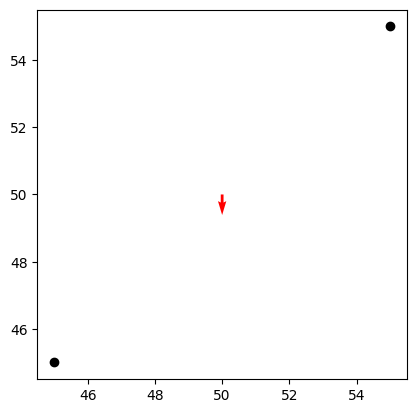

In [ ]:
#カメラとシカを自由な位置に設定し，評価値を求めるプログラム
import random
import sys
import math
from scipy import interpolate
from google.colab import files

print("シカの位置は(50, 50)です．向きはy軸負の方向を向いています．")
deer_x = [50]
deer_y = [50]
deer = [(deer_x[0], deer_y[0])]

x_latent = [50]
y_latent = [10]


camera_x = []
camera_y = []
camera_x.append(float(input("1台目のカメラのx座標を入力してください．")))
camera_y.append(float(input("1台目のカメラのy座標を入力してください．")))
camera_x.append(float(input("2台目のカメラのx座標を入力してください．")))
camera_y.append(float(input("2台目のカメラのy座標を入力してください．")))
camera = [(camera_x[0], camera_y[0]), (camera_x[1], camera_y[1])]

print(camera)

e = eval(deer[0], camera, (x_latent[0], y_latent[0]))
print("評価値")
print(round(e,2))

#フィールド表示
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(camera_x[0], camera_y[0], color = 'black', zorder=1)
plt.scatter(camera_x[1], camera_y[1], color = 'black', zorder=1)

x_quiver = x_latent[0] - deer_x[0]
y_quiver = y_latent[0] - deer_y[0]
plt.quiver(deer_x[0], deer_y[0], x_quiver, y_quiver,angles='xy',scale_units='xy', color = 'red')

ax.set_aspect('equal', adjustable='box')